In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from matplotlib import pyplot as plt
import pathlib
import joblib
from lb2jpsil import lorentz

In [2]:
## Self explanatory
save_plots = True

## Toggle plot titles (off for thesis and papers, generally speaking)
show_titles = False

## Toggle plot grid
show_grid = True

## Black and white?
black_and_white = True

## Drop event if DTF_FixJPsiLambda failed?
dtf_success = True

## Veto physical background
b0_veto = True

## Select signal region ([5508.5, 5731.8] MeV/c^2)
only_sig_region = True

In [3]:
saved_models = {
    ## BALANCE
    ## Higher overtraining. Slightly better performance in test (fractions of percentage)
    'sachiel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'balance',
        'learning_rate' : 0.010,
        'max_leaf_nodes' : 200,
        'max_iter' : 5000,
        'soft_threshold': 0.7,
        'hard_threshold': 0.9924
    },
    ## Lower ovetraining. Looks better under K-S test. Slightly worse performance in test (fractions of percentage)
    'shamshel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'balance',
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 2500,
        'soft_threshold': 0.7,
        'hard_threshold': 0.985
    },
    ## BKGSKEW
    ## From an overtraining standpoint, this is the better one of the bkgskew
    'ramiel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 1500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.656
    },
    ## This has quite more overtraining, but loses less signal
    'israfel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.015,
        'max_leaf_nodes' : 100,
        'max_iter' : 1500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.714
    },
    ## Salvatore's HBDT, for performance comparison.
    ## Somewhat similar to israfel, does not match his original HBDT
    'sandalphon': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.01,
        'max_leaf_nodes' : 100,
        'max_iter' : 2500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.637
    }
}

In [4]:
## Either one of the names in list(saved_models) or 'temp' for custom new model
model_to_use = 'shamshel'

if model_to_use in saved_models:
    daughter_momenta = saved_models[model_to_use]['daughter_momenta']
    dataset_type = saved_models[model_to_use]['dataset_type']
    training_params = {key: saved_models[model_to_use][key] for key in ['learning_rate', 'max_leaf_nodes', 'max_iter']}
    hard_threshold = saved_models[model_to_use]['hard_threshold']
elif model_to_use == 'temp':
    ## Proton and pion momenta
    ## 'VF': use VF momenta
    ## 'DTF': use DTF momenta w/ JPsi m.c.
    ## 'DTFL': use DTF momenta w/ JPsi and Lambda m.c.
    ## 'NO': don't use any momenta for Lambda daughter particles
    daughter_momenta = 'DTF'

    ## Two options:
    ## 'balance': same number of training events for signal and bkg
    ## 'bkgskew' uses 4 mln events of bkg, 500k of signal
    dataset_type = 'bkgskew'

    training_params = {
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 5000
    }
    
    hard_threshold = 0.9
else:
    raise ValueError

In [5]:
if dataset_type not in ['balance', 'bkgskew']:
    raise ValueError

In [6]:
if daughter_momenta == 'VF':
    p_momenta = ['p_PT', 'p_PZ']
    pim_momenta = ['pim_PT', 'pim_PZ']
elif daughter_momenta == 'DTF':
    p_momenta = ['DTF_FixJPsi_p_PT', 'DTF_FixJPsi_p_PZ']
    pim_momenta = ['DTF_FixJPsi_pim_PT', 'DTF_FixJPsi_pim_PZ']
elif daughter_momenta == 'DTFL':
    p_momenta = ['DTF_FixJPsiLambda_p_PT', 'DTF_FixJPsiLambda_p_PZ']
    pim_momenta = ['DTF_FixJPsiLambda_pim_PT', 'DTF_FixJPsiLambda_pim_PZ']
elif daughter_momenta == 'NO':
    p_momenta = []
    pim_momenta = []
else:
    raise ValueError(daughter_momenta + " is not a valid option for momenta usage.")

In [7]:
if dataset_type == 'balance':
    dataset_suffix = 'BAL'
else:
    dataset_suffix = 'SKEW'

classifier_dump_filename = (
    'HBDT_'
    + daughter_momenta
    + '_' + str(training_params['learning_rate'])
    + '_' + str(training_params['max_leaf_nodes'])
    + '_' + str(training_params['max_iter'])
    + '_' + dataset_suffix
)

classifier_dump_filename

'HBDT_DTF_0.003_100_2500_BAL'

In [8]:
## Create plots directory, if missing
repo_directory = str(pathlib.Path.home()) + '/lambda-emdm-measurement/'
state_directory = str(pathlib.Path.home()) + '/classifier-studies/' + '20_HBDT/' + 'saved_states/'

plot_directory = (
    repo_directory + 'plots/'
    + 'proton_angular_distributions/'
)

pathlib.Path(plot_directory).mkdir(parents=True, exist_ok=True)

In [9]:
path_to_hd5_files = str(pathlib.Path.home()) + '/data/'
input_mc = path_to_hd5_files + 'LHCbMC_2016-2017-2018_MagUpDown_Lb2JPsiL_Ttracks_v12.h5'
input_data = path_to_hd5_files + 'LHCbData_2016-2017-2018_MagUpDown_Dimuon_Ttracks_v2.h5'

# Data prepping
## Import Monte Carlo data

In [10]:
def p_modulus(px, py, pz):
    return np.sqrt(px**2 + py**2 + pz**2)

def transverse_p_modulus(px, py):
    return np.sqrt(px**2 + py**2)

In [11]:
df_reco = pd.read_hdf(input_mc, key='LHCbMC_Lb')
df_truth = pd.read_hdf(input_mc, key='LHCbMCTruth_Lb')
df_mc = pd.merge(df_truth.loc[df_truth['Rec_key'] >= 0], df_reco, left_index=True, right_on='MC_key')
df_mc = df_mc.loc[(df_mc['MC_key'] >= 0) & (df_mc['Rec_key'] >= 0)]

#del(df_reco, df_truth)
del(df_reco)

In [12]:
def scalar_product(v1, v2):
    return v1[0] * v2[0] + v1[1] * v2[1] + v1[2] * v2[2]

In [13]:
def norm(v):
    return np.sqrt(v[0]**2 + v[1]**2 + v[2]**2)

In [14]:
## Compute variables needed for Armenteros-Podolanski plots
def compute_momentum_asymmetry(
    df: pd.DataFrame, # The DataFrame that will be modified
    mother: str,      # Symbol of the mother: L or KS0
    daughter_1: str,  # Symbol of the conventionally positive daughter
    daughter_2: str,  # Symbol of the conventionally negative daughter
    prefix: str,      # Usually either 'MCTRUTH_' or 'DTF_FixJPsi_'
):

    for coord in ['X', 'Y', 'Z']:
        df[f'{prefix}{mother}_P{coord}'] = df[f'{prefix}{daughter_1}_P{coord}'] + df[f'{prefix}{daughter_2}_P{coord}']

    mother_uv = lorentz.unit_vector(np.array([df[f'{prefix}{mother}_PX'], df[f'{prefix}{mother}_PY'], df[f'{prefix}{mother}_PZ']]))
    part1_p = np.array([df[f'{prefix}{daughter_1}_PX'], df[f'{prefix}{daughter_1}_PY'], df[f'{prefix}{daughter_1}_PZ']])
    part2_p = np.array([df[f'{prefix}{daughter_2}_PX'], df[f'{prefix}{daughter_2}_PY'], df[f'{prefix}{daughter_2}_PZ']])

    part1_pL = scalar_product(part1_p, mother_uv)
    part2_pL = scalar_product(part2_p, mother_uv)

    part1_pT = part1_p - part1_pL * mother_uv
    part2_pT = part2_p - part2_pL * mother_uv

    part1_pT_norm = norm(part1_pT)
    part2_pT_norm = norm(part2_pT)

    df[f'{prefix}pL1'] = part1_pL
    df[f'{prefix}pL2'] = part2_pL
    df[f'{prefix}pT1'] = part1_pT_norm
    df[f'{prefix}pT2'] = part2_pT_norm
    
    df[f'{prefix}p_asymm'] = (df[f'{prefix}pL1'] - df[f'{prefix}pL2'])/(df[f'{prefix}pL1'] + df[f'{prefix}pL2'])

In [15]:
df_mc_norm = df_mc.loc[df_mc['MCTRUTH_L_ID']  == 3122].copy()
df_mc_bar = df_mc.loc[df_mc['MCTRUTH_L_ID']  == -3122].copy()

del(df_mc)

compute_momentum_asymmetry(df_mc_norm, 'L', 'p', 'pim', 'MCTRUTH_')
compute_momentum_asymmetry(df_mc_bar, 'L', 'pim', 'p', 'MCTRUTH_')
compute_momentum_asymmetry(df_mc_norm, 'L', 'p', 'pim', 'DTF_FixJPsi_')
compute_momentum_asymmetry(df_mc_bar, 'L', 'pim', 'p', 'DTF_FixJPsi_')

df_mc = pd.concat([df_mc_norm, df_mc_bar])

del(df_mc_norm, df_mc_bar)

/home/adegenna/lhcb-lb2jpsil/lb2jpsil/lorentz.py:39: RuntimeWarning: overflow encountered in square
  mag = np.sqrt(v[0]**2 + v[1]**2 + v[2]**2)
/home/adegenna/apollo/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  


In [16]:
armenteros_cuts = (abs(df_mc['DTF_FixJPsi_p_asymm']) > 0.5)

In [17]:
jpsi_pdg_mass = 3096.900
b0_pdg_mass = 5279.61
b0_veto_threshold = 70

In [18]:
## Missing "combined" invariant masses (for Lambda->p pim and Lambdab->JPsi Lambda)
## These are the AM in the DaVinci config file. Did Salvatore implement them somewhere?

pion_p_cuts = (
    (p_modulus(df_mc['pim_PX'], df_mc['pim_PY'], df_mc['pim_PZ']) > 2000)
    & (p_modulus(df_mc['pim_PX'], df_mc['pim_PY'], df_mc['pim_PZ']) < 5e5)
)

proton_p_cuts = (
    (p_modulus(df_mc['p_PX'], df_mc['p_PY'], df_mc['p_PZ']) > 10000)
    & (p_modulus(df_mc['p_PX'], df_mc['p_PY'], df_mc['p_PZ']) < 5e5)
)

proton_pt_cuts = transverse_p_modulus(df_mc['p_PX'], df_mc['p_PY']) > 400

lambda_m_cuts = (df_mc['L_M'] > 600) & (df_mc['L_M'] < 1500)
lambda_mm_cuts = df_mc['L_MM'] < 1500
lambda_z_cuts = (df_mc['L_ENDVERTEX_Z'] > 5500) & (df_mc['L_ENDVERTEX_Z'] < 8500)
lambda_dira_cuts = df_mc['L_BPVDIRA'] > 0.9999
lambda_ipchi2_cuts = df_mc['L_BPVIPCHI2'] < 200
lambda_vdchi2_cuts = df_mc['L_BPVVDCHI2'] < 2e7
lambda_chi2_cuts = df_mc['L_VFASPF_CHI2_VDOF'] < 750
lambda_pt_cuts = transverse_p_modulus(df_mc['L_PX'], df_mc['L_PY']) > 450

jpsi_m_cuts = abs(df_mc['Jpsi_M'] - jpsi_pdg_mass) < 90

lambdab_m_cuts = df_mc['Lb_M'] < 8500
lambdab_dira_cuts = abs(df_mc['Lb_BPVDIRA']) > 0.99
lambdab_ipchi2_cuts = df_mc['Lb_BPVIPCHI2'] < 1750
lambdab_chi2_cuts = df_mc['Lb_VFASPF_CHI2_VDOF'] < 150

dtf_success_cuts = df_mc['DTF_FixJPsiLambda_status'] == 'Success'

b0_veto_cuts = (df_mc['DTF_FixJPsiLambda_PIDSubs_status'] != 'Success') | (np.abs(df_mc['DTF_FixJPsiLambda_PIDSubs_Lb_M'] - b0_pdg_mass) > b0_veto_threshold)

In [19]:
pre_selection_cuts = (
    pion_p_cuts &
    proton_p_cuts &
    proton_pt_cuts &
    lambda_m_cuts &
    lambda_mm_cuts &
    lambda_z_cuts &
    lambda_dira_cuts &
    lambda_ipchi2_cuts &
    lambda_vdchi2_cuts &
    lambda_chi2_cuts &
    lambda_pt_cuts &
    jpsi_m_cuts &
    lambdab_m_cuts &
    lambdab_dira_cuts &
    lambdab_ipchi2_cuts &
    lambdab_chi2_cuts
)

if dtf_success:
    pre_selection_cuts = pre_selection_cuts & dtf_success_cuts
    
if b0_veto:
    pre_selection_cuts = pre_selection_cuts & b0_veto_cuts & armenteros_cuts

#df_mc[pre_selection_cuts]

## Import Run 2 data

In [20]:
df_data = pd.read_hdf(input_data, key='LHCbData')

In [21]:
df_data_norm = df_data.loc[df_data['L_ID']  == 3122].copy()
df_data_bar = df_data.loc[df_data['L_ID']  == -3122].copy()

del(df_data)

compute_momentum_asymmetry(df_data_norm, 'L', 'p', 'pim', 'DTF_FixJPsi_')
compute_momentum_asymmetry(df_data_bar, 'L', 'pim', 'p', 'DTF_FixJPsi_')

df_data = pd.concat([df_data_norm, df_data_bar])

del(df_data_norm, df_data_bar)

/home/adegenna/lhcb-lb2jpsil/lb2jpsil/lorentz.py:39: RuntimeWarning: overflow encountered in square
  mag = np.sqrt(v[0]**2 + v[1]**2 + v[2]**2)
/home/adegenna/apollo/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  


In [22]:
data_armenteros_cuts = (abs(df_data['DTF_FixJPsi_p_asymm']) > 0.5)

In [23]:
data_dtf_cuts = df_data['DTF_FixJPsiLambda_status'] == 'Success'
data_b0_veto_cuts = (df_data['DTF_FixJPsiLambda_PIDSubs_status'] != 'Success') | (np.abs(df_data['DTF_FixJPsiLambda_PIDSubs_Lb_M'] - b0_pdg_mass) > b0_veto_threshold)

In [24]:
data_cuts = pd.Series(True, index=df_data.index)

if dtf_success:
    data_cuts = data_cuts & data_dtf_cuts

if b0_veto:
    data_cuts = data_cuts & data_b0_veto_cuts & data_armenteros_cuts

#df_data[data_cuts]

## Add derived variables

In [25]:
def add_derived_variables(
    df: pd.DataFrame
) -> None:
    df['p_PT'] = transverse_p_modulus(df['p_PX'], df['p_PY'])
    df['DTF_FixJPsi_p_PT'] = transverse_p_modulus(df['DTF_FixJPsi_p_PX'], df['DTF_FixJPsi_p_PY'])
    df['DTF_FixJPsiLambda_p_PT'] = transverse_p_modulus(df['DTF_FixJPsiLambda_p_PX'], df['DTF_FixJPsiLambda_p_PY'])
    df['pim_PT'] = transverse_p_modulus(df['pim_PX'], df['pim_PY'])
    df['DTF_FixJPsi_pim_PT'] = transverse_p_modulus(df['DTF_FixJPsi_pim_PX'], df['DTF_FixJPsi_pim_PY'])
    df['DTF_FixJPsiLambda_pim_PT'] = transverse_p_modulus(df['DTF_FixJPsiLambda_pim_PX'], df['DTF_FixJPsiLambda_pim_PY'])
    df['Jpsi_PT'] = transverse_p_modulus(df['Jpsi_PX'], df['Jpsi_PY'])
    
    dtf_success_mapper = {
        'Success': 0.0,
        'Failed': 1.0,
        'NonConverged': 3.0
    }

    df.replace({'DTF_FixJPsi_status': dtf_success_mapper}, inplace=True)
    df.replace({'DTF_FixJPsiLambda_status': dtf_success_mapper}, inplace=True)

In [26]:
add_derived_variables(df_mc)
add_derived_variables(df_data)

## Drop events not passing the prefilter

In [27]:
df_mc.drop(df_mc[~pre_selection_cuts].index, inplace=True)
df_data.drop(df_data[~data_cuts].index, inplace=True)

## Score HBDT and keep events above hard threshold

In [28]:
saved_state_file = state_directory + classifier_dump_filename + '.joblib'
HBDT = joblib.load(saved_state_file)

In [29]:
fixed_features = [
    'Jpsi_PT',
    'Jpsi_PZ',
    'L_ENDVERTEX_X',
    'L_ENDVERTEX_Y',
    'L_ENDVERTEX_Z',
    'L_BPVDIRA',
    'Lb_BPVDIRA',
    'L_VFASPF_CHI2_VDOF',
    'Lb_VFASPF_CHI2_VDOF',
    'L_BPVIPCHI2',
    'Lb_BPVIPCHI2',
    'L_BPVVDCHI2',
    'Lb_BPVVDCHI2',
    'DTF_FixJPsi_status',
    'DTF_FixJPsiLambda_status'
]

features = p_momenta + pim_momenta + fixed_features

In [30]:
mc_predicted = HBDT.predict_proba(df_mc.loc[:, features].to_numpy())[:,1]
df_mc['HBDT'] = mc_predicted
mc_pass_threshold = df_mc['HBDT'] > hard_threshold

In [31]:
data_predicted = HBDT.predict_proba(df_data.loc[:, features].to_numpy())[:,1]
df_data['HBDT'] = data_predicted
data_pass_threshold = df_data['HBDT'] > hard_threshold
data_pass_hard_bkg_threshold = df_data['HBDT'] < 0.001

In [32]:
df_mc.drop(df_mc[~mc_pass_threshold].index, inplace=True)
df_deep_background = df_data[data_pass_hard_bkg_threshold].copy()
df_data.drop(df_data[~data_pass_threshold].index, inplace=True)

del(mc_predicted, data_predicted)

One last thing: excise events outside of the desired invariant mass window.

In [33]:
if only_sig_region:
    lower_limit_mass = 5496.2
    upper_limit_mass = 5744
else:
    lower_limit_mass = 5000
    upper_limit_mass = 6200

mc_Lb_invmass_cut = ((df_mc['DTF_FixJPsiLambda_Lb_M'] > lower_limit_mass) & (df_mc['DTF_FixJPsiLambda_Lb_M'] < upper_limit_mass))
data_Lb_invmass_cut = ((df_data['DTF_FixJPsiLambda_Lb_M'] > lower_limit_mass) & (df_data['DTF_FixJPsiLambda_Lb_M'] < upper_limit_mass))
bkg_Lb_invmass_cut = ((df_deep_background['DTF_FixJPsiLambda_Lb_M'] > 4000) & (df_deep_background['DTF_FixJPsiLambda_Lb_M'] < 7000))

In [34]:
df_mc.drop(df_mc[~mc_Lb_invmass_cut].index, inplace=True)
df_data.drop(df_data[~data_Lb_invmass_cut].index, inplace=True)
df_deep_background.drop(df_deep_background[~bkg_Lb_invmass_cut].index, inplace=True)

In [35]:
df_mc

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,DTF_FixJPsi_pT2,DTF_FixJPsi_p_asymm,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,HBDT
Rec_key,,,,,,,,,,,,,,,,,,,,,
56,1.0630,-0.1569,14.631200,-16.393600,-267.315704,7429.070312,19.139999,-1164.579956,32903.449219,-108.959999,...,107.576622,0.725317,1677.147461,1222.470947,1180.346313,260.234802,254.823410,243.301285,2582.130859,0.986191
93,0.8698,-0.0087,-61.167301,5.258500,178.656799,7477.866211,134.649994,1566.119995,66334.351562,-87.529999,...,93.933685,0.616246,1914.452026,1541.024048,1483.825928,364.727753,379.656891,364.195160,1196.638428,0.989228
118,1.1396,-0.2901,6.363200,23.924900,-151.806702,7417.714844,183.149994,-964.179993,51779.789062,0.160000,...,90.671173,0.745712,1158.645996,962.766296,981.719482,242.024384,239.956055,246.622147,3400.177246,0.987851
150,1.0411,-0.3097,-19.698900,858.356018,-212.597198,6700.881348,5178.000000,-1212.050049,39903.679688,928.630005,...,210.187805,0.663270,7280.269043,6886.478516,5292.452637,876.763123,1170.399292,961.289429,5073.340332,0.987371
244,0.7228,-0.5554,43.125599,-19.334801,142.030197,7028.507324,-34.930000,955.659973,47098.750000,-125.769997,...,99.790291,0.681268,1017.233459,950.212402,952.590698,285.365601,226.046829,226.857254,2638.750244,0.986135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366202,0.5128,0.5682,-13.609200,-461.977905,581.789673,6773.900879,-1876.209961,2406.250000,28402.410156,-615.969971,...,109.938141,-0.541443,2337.891846,3189.538330,2945.192383,1137.083008,1066.396973,930.918518,1032.592041,0.996632
366203,0.4704,-0.4386,-19.485800,-111.744202,-138.079300,6616.266602,-747.200012,-836.380005,39088.210938,-73.599998,...,81.999931,-0.602113,1158.625732,1024.985840,1049.035034,297.850037,277.218781,286.209717,2787.019287,0.987928
366213,0.6122,-0.0708,87.435204,-438.150391,-214.334595,6468.198730,-3648.800049,-1744.800049,54030.121094,-607.150024,...,85.426590,-0.749597,3792.759766,3998.337891,4049.203369,903.033020,660.581848,681.052551,2518.792969,0.995600


In [36]:
df_data

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsi_pT2,DTF_FixJPsi_p_asymm,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,HBDT
1243,0.570611,-0.048790,9.819603,-219.870300,-23.170826,6890.049316,0.5706,-0.0484,9.826700,-2135.995850,...,59.753120,0.846256,2118.871582,2296.816406,2250.925537,25.952250,128.293900,133.510849,1713.736938,0.991741
28004,1.020999,1.607981,63.884747,34.099216,534.048462,6518.728516,1.0211,1.6079,63.884602,552.369690,...,192.046509,0.565055,3609.034668,4370.840820,3929.881592,1530.654907,1329.929810,1164.037354,1783.447632,0.990346
37728,0.795410,-0.045465,38.450478,-451.465973,338.912628,6704.439941,0.7954,-0.0455,38.450298,-1892.045654,...,97.638100,0.773516,2275.273926,2381.954834,2343.148193,105.937561,195.158646,200.321213,2073.057129,0.994386
78625,0.841473,-0.682757,41.748272,101.145950,-596.133850,7174.723633,0.8414,-0.6828,41.749298,510.759491,...,47.757023,0.534894,2244.927246,2196.920898,2198.042725,715.775330,726.800598,730.221436,1094.929565,0.994478
82179,0.783685,0.050663,28.319233,-610.796143,540.798767,7263.181641,0.7837,0.0507,28.319599,-2058.423828,...,93.690315,0.587484,2142.329102,2687.896973,2589.229736,727.092896,725.528625,703.443237,4781.413574,0.992864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43609379,1.525888,0.445957,19.266209,193.688568,83.676277,5877.111328,1.5258,0.4459,19.265800,825.459412,...,85.522552,-0.607817,506.494537,757.013428,749.527954,494.092651,163.727234,175.837631,4731.324219,0.988129
43614266,0.594955,0.216254,6.746526,140.687988,-30.582621,6513.723633,0.5949,0.2163,6.747600,1104.205933,...,74.233513,-0.824181,873.152832,1018.423096,1028.300903,317.849548,123.651794,105.995758,2774.034912,0.990466
43626085,-0.050582,-0.765192,33.898277,98.503334,-340.338867,7844.226562,-0.0506,-0.7652,33.898602,544.916626,...,47.763611,-0.855526,1853.875854,1699.981079,1639.573242,173.015381,176.300110,176.083267,3685.975342,0.991810
43628854,0.764695,0.653705,59.725788,92.241959,382.796448,6405.751953,0.7647,0.6537,59.725700,1005.348145,...,90.461586,-0.565772,3251.064941,3284.836182,3247.045410,1212.331909,863.015869,845.922119,5351.891602,0.995809


In [37]:
df_deep_background

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsi_pT2,DTF_FixJPsi_p_asymm,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,HBDT
1920,0.274885,-0.867234,-22.956949,-86.150719,-117.302788,6148.786133,0.2737,-0.8651,-22.965401,-497.163666,...,345.247559,0.756016,999.873840,453.532318,434.891083,465.926086,363.937317,149.462357,574.942688,0.000998
4149,1.335156,0.033475,-22.175732,-64.709488,-32.365780,5748.362793,1.3332,0.0327,-22.190901,-533.658508,...,269.921173,0.532504,1075.132690,441.245605,200.161728,532.429565,223.933228,39.613049,4613.840820,0.000946
5416,0.759461,-0.064041,-40.709782,-56.643002,8.366840,6116.257812,0.7601,-0.0656,-40.696800,-504.763641,...,317.946381,0.635907,959.299438,485.026855,233.657639,475.564636,280.869446,89.267479,3935.410889,0.000957
6546,-0.105300,0.203952,46.509632,-69.137360,22.558865,6637.936523,-0.1080,0.2057,46.526600,-500.734436,...,375.638824,0.686415,921.369934,528.368408,221.160477,419.890137,347.805176,77.481796,3225.670410,0.000986
6992,1.544088,-0.052092,-10.159805,-51.815277,-39.921043,5752.835449,1.5437,-0.0523,-10.162400,-514.455200,...,325.954041,0.563705,992.638855,492.445129,209.600464,460.486725,290.670654,66.548485,951.552490,0.000917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43646288,1.777307,1.588380,25.972660,-65.538864,-14.025329,5918.910156,1.7775,1.5894,25.966101,-462.605011,...,350.202209,-0.531635,989.301514,179.229645,135.810883,554.521057,405.769684,95.482361,3515.730957,0.000940
43646358,1.559767,0.049752,-3.899897,-80.320648,-13.447189,5875.314941,1.5597,0.0501,-3.900400,-547.332031,...,27.620007,-0.676077,1022.336426,221.310257,321.480103,459.850739,34.911575,63.196865,1215.756958,0.000862
43646398,1.877986,-0.370415,-15.053658,-40.605473,-10.034454,6171.655762,1.8779,-0.3704,-15.052800,-494.485443,...,312.253998,-0.589615,1004.260010,421.009735,184.636154,455.384888,284.839508,76.267746,2736.374512,0.000869
43647921,1.151930,-0.660758,-48.365246,-131.176910,-50.406845,5958.978027,1.1516,-0.6596,-48.367901,-471.223999,...,157.031509,-0.597563,944.326172,360.806793,332.785309,469.676208,105.653633,91.577438,5214.791016,0.000896


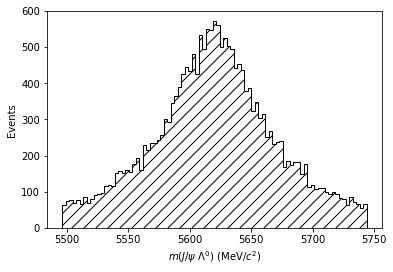

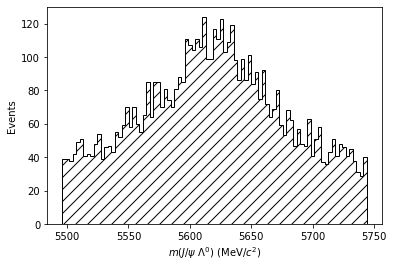

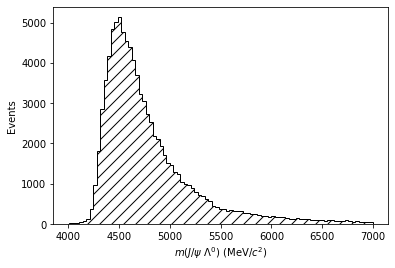

In [38]:
common_plot_params = {
    'bins': 87,
    'histtype': 'stepfilled',
    'facecolor': 'none',
    'edgecolor': 'black',
    'hatch': '//'
}

xlabel = "$m(J/\psi~\Lambda^0)$ (MeV/$c^2$)"
ylabel = 'Events'

plt.hist(df_mc['DTF_FixJPsiLambda_Lb_M'], **common_plot_params)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

plt.hist(df_data['DTF_FixJPsiLambda_Lb_M'], **common_plot_params)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

plt.hist(df_deep_background['DTF_FixJPsiLambda_Lb_M'], **common_plot_params)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

# Compute proton helicity angles

In [39]:
def norm(v):
    return np.sqrt(v[0]**2 + v[1]**2 + v[2]**2)

In [40]:
def calculate_helicity_angle(
    df: pd.DataFrame,
    daughter: str,
    mother: str,
    daughter_suffix: str,
    mother_suffix: str,
    angle_suffix: str = None
):
    if angle_suffix is not None:
        angle_suffix = '_' + angle_suffix
    else:
        angle_suffix = ''
    
    daughter_p = np.array([
        df[f'{daughter}_PX_{daughter_suffix}'],
        df[f'{daughter}_PY_{daughter_suffix}'],
        df[f'{daughter}_PZ_{daughter_suffix}']])
    mother_p = np.array([
        df[f'{mother}_PX_{mother_suffix}'],
        df[f'{mother}_PY_{mother_suffix}'],
        df[f'{mother}_PZ_{mother_suffix}']])
    angle = lorentz.cos_angle(mother_p, daughter_p)
    df[f'{daughter}_Theta{angle_suffix}'] = angle

## What it does: computes momenta in Lambda frame and Lambdab frames
## Then computes angle between p(p) in Lambda frame and p(Lambda) in Lambdab frame 
def calculate_proton_lambda_helicity_angle(df, prefix):
    calculate_at_rest_kine(df, {
        f'{prefix}p' : 938.27208816,
        f'{prefix}pim' : 139.57018,
    }, suffix_end='LambdaFrame')
    calculate_at_rest_kine(df, {
        f'{prefix}p' : 938.27208816,
        f'{prefix}pim' : 139.57018,
        f'{prefix}mup' : 105.6583755,
        f'{prefix}mum' : 105.6583755,
    }, suffix_end='LambdabFrame')
    for coord in ['X', 'Y', 'Z']:
        df[f'{prefix}L_P{coord}_LambdabFrame'] = df[f'{prefix}p_P{coord}_LambdabFrame'] + df[f'{prefix}pim_P{coord}_LambdabFrame']
    calculate_helicity_angle(df, f'{prefix}p', f'{prefix}L',
                             daughter_suffix='LambdaFrame', mother_suffix='LambdabFrame')

## Same thing as above, but use LambdaFromLambdabFrame for the p frame. Instead of going lab->Lambda,
## we do lab->Lambdab->Lambda for the proton
def calculate_proton_lambda_helicity_angle_from_lambdab_frame(df, prefix):
    calculate_at_rest_kine(df, {
        f'{prefix}p' : 938.27208816,
        f'{prefix}pim' : 139.57018,
        f'{prefix}mup' : 105.6583755,
        f'{prefix}mum' : 105.6583755,
    }, suffix_end='LambdabFrame')

    for coord in ['X', 'Y', 'Z']:
        df[f'{prefix}L_P{coord}_LambdabFrame'] = df[f'{prefix}p_P{coord}_LambdabFrame'] + df[f'{prefix}pim_P{coord}_LambdabFrame']

    calculate_at_rest_kine(df, {
        f'{prefix}p' : 938.27208816,
        f'{prefix}pim' : 139.57018,
    }, suffix_start='LambdabFrame', suffix_end='LambdaFromLambdabFrame')
        
    calculate_helicity_angle(
        df, f'{prefix}p', f'{prefix}L',
        daughter_suffix='LambdaFromLambdabFrame', mother_suffix='LambdabFrame', angle_suffix='IFM')

In [41]:
def scalar_product(v1, v2):
    return v1[0] * v2[0] + v1[1] * v2[1] + v1[2] * v2[2]

In [42]:
def cross_product(v1, v2):
    u0 = v1[1] * v2[2] - v1[2] * v2[1]
    u1 = v1[2] * v2[0] - v1[0] * v2[2]
    u2 = v1[0] * v2[1] - v1[1] * v2[0]
    
    return np.array([u0, u1, u2])

In [43]:
def calculate_at_rest_kine(
    df: pd.DataFrame,
    daughters: dict,
    suffix_start: str = None,
    suffix_end: str = 'Star'
):
    
    if suffix_start is not None:
        suffix_start = '_' + suffix_start
    else:
        suffix_start = ''
    
    daughters_p = {
        part_name: lorentz.four_vector_from_PXPYPZM(
            df[f'{part_name}_PX{suffix_start}'],
            df[f'{part_name}_PY{suffix_start}'],
            df[f'{part_name}_PZ{suffix_start}'],
            part_mass)
        for part_name, part_mass in daughters.items()
    }
    
    mother_p = sum(daughters_p.values())
    daughters_p_star = {
        part_name: lorentz.boost_from_mom(part_p, mother_p)
        for part_name, part_p in daughters_p.items()
    }
    
    for part_name, p_star in daughters_p_star.items():
        df[f'{part_name}_PX_{suffix_end}'] = p_star[0]
        df[f'{part_name}_PY_{suffix_end}'] = p_star[1]
        df[f'{part_name}_PZ_{suffix_end}'] = p_star[2]
        df[f'{part_name}_P_{suffix_end}'] = np.sqrt(p_star[0]**2 + p_star[1]**2 + p_star[2]**2)

In [44]:
def calculate_proton_lambda_angular_distribution(df, prefix):
    calculate_at_rest_kine(df, {
        f'{prefix}p' : 938.27208816,
        f'{prefix}pim' : 139.57018,
        f'{prefix}mup' : 105.6583755,
        f'{prefix}mum' : 105.6583755,
    }, suffix_end='LambdabFrame')
    
    for coord in ['X', 'Y', 'Z']:
        df[f'{prefix}L_P{coord}_LambdabFrame'] = df[f'{prefix}p_P{coord}_LambdabFrame'] + df[f'{prefix}pim_P{coord}_LambdabFrame']
    
    calculate_at_rest_kine(df, {
        f'{prefix}p' : 938.27208816,
        f'{prefix}pim' : 139.57018,
    }, suffix_start='LambdabFrame', suffix_end='LambdaFromLambdabFrame')
    

    Lambda_p_in_Lambdab_frame = np.array([
        df[f'{prefix}L_PX_LambdabFrame'],
        df[f'{prefix}L_PY_LambdabFrame'],
        df[f'{prefix}L_PZ_LambdabFrame']
    ])
    
    Lambda_p_in_Lambdab_frame_hat = lorentz.unit_vector(Lambda_p_in_Lambdab_frame)
    
    for coord in ['X', 'Y', 'Z']:
        df[f'{prefix}Lb_P{coord}'] = (
            df[f'{prefix}p_P{coord}']
            + df[f'{prefix}pim_P{coord}']
            + df[f'{prefix}mum_P{coord}']
            + df[f'{prefix}mup_P{coord}']
        )
    
    z0_in_Lambdab_frame = lorentz.unit_vector(np.array([df[f'{prefix}Lb_P{coord}'] for coord in ['X', 'Y', 'Z']]))
    z0_in_Lambdab_frame_parallel = scalar_product(z0_in_Lambdab_frame, Lambda_p_in_Lambdab_frame_hat)
    
    b_z0PerpLambda = z0_in_Lambdab_frame - z0_in_Lambdab_frame_parallel * Lambda_p_in_Lambdab_frame_hat
    x2_in_Lambdab_frame = - b_z0PerpLambda / norm(b_z0PerpLambda)
    
    x0_in_Lambda_frame = x2_in_Lambdab_frame
    z0_in_Lambda_frame = Lambda_p_in_Lambdab_frame_hat
    y0_in_Lambda_frame = cross_product(z0_in_Lambda_frame, x0_in_Lambda_frame)
    
    proton_p_IFM = np.array([
        df[f'{prefix}p_PX_LambdaFromLambdabFrame'],
        df[f'{prefix}p_PY_LambdaFromLambdabFrame'],
        df[f'{prefix}p_PZ_LambdaFromLambdabFrame']])
    
    proton_p_IFM_hat = lorentz.unit_vector(proton_p_IFM)
    
    proton_y_projection = scalar_product(proton_p_IFM_hat, y0_in_Lambda_frame)
    proton_x_projection = scalar_product(proton_p_IFM_hat, x0_in_Lambda_frame)
    
    theta = scalar_product(proton_p_IFM_hat, z0_in_Lambda_frame)
    phi = np.arctan2(proton_y_projection, proton_x_projection)
    
    df[f'{prefix}p_Phi'] = phi
    df[f'{prefix}p_CosTheta'] = theta

In [45]:
calculate_proton_lambda_angular_distribution(df_truth, 'MCTRUTH_')

In [46]:
calculate_proton_lambda_angular_distribution(df_mc, 'MCTRUTH_')
calculate_proton_lambda_angular_distribution(df_mc, 'DTF_FixJPsiLambda_')

In [47]:
calculate_proton_lambda_angular_distribution(df_data, 'DTF_FixJPsiLambda_')

In [48]:
calculate_proton_lambda_angular_distribution(df_deep_background, 'DTF_FixJPsiLambda_')

# Proton $\theta$ angle
## Simulation
### All simulated events

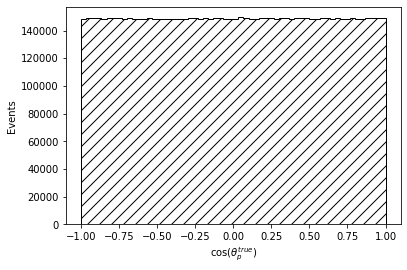

In [49]:
hist_arguments = {
    'bins': 60,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'hatch': '//'
}

xlabel = r"$\cos(\theta_p^{true})$"
ylabel = "Events"
title = r"Proton true $\theta$ helicity angle" + "\n" + "(MC simulation, truth sample)"
file_name = 'MCTRUTH_theta_true'

plt.hist(df_truth['MCTRUTH_p_CosTheta'], **hist_arguments)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_titles:
    plt.title(title)
    
if save_plots:
    plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

plt.show()

### Only reconstructed events

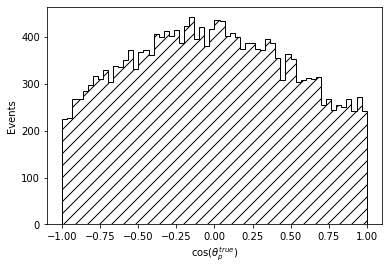

In [50]:
hist_arguments = {
    'bins': 60,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'hatch': '//'
}

xlabel = r"$\cos(\theta_p^{true})$"
ylabel = "Events"
title = r"Proton true $\theta$ helicity angle" + "\n" + "(MC simulation, reco sample)"
file_name = 'MCRECO_theta_true'

plt.hist(df_mc['MCTRUTH_p_CosTheta'], **hist_arguments)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_titles:
    plt.title(title)
    
if save_plots:
    plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

plt.show()

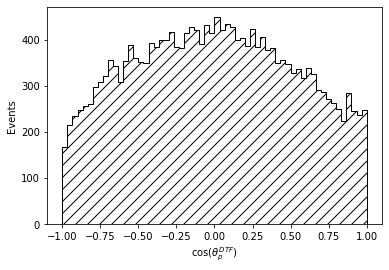

In [51]:
hist_arguments = {
    'bins': 60,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'hatch': '//'
}

xlabel = r"$\cos(\theta_p^{DTF})$"
ylabel = "Events"
title = r"Proton DTF $\theta$ helicity angle" + "\n" + "(MC simulation, reco sample)"
file_name = 'MCRECO_theta_reco'

plt.hist(df_mc['DTF_FixJPsiLambda_p_CosTheta'], **hist_arguments)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_titles:
    plt.title(title)
    
if save_plots:
    plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

plt.show()

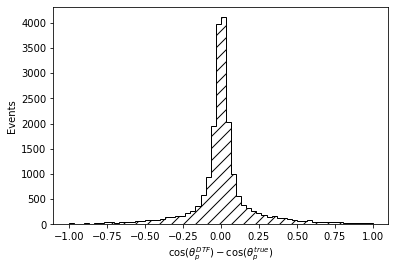

In [52]:
hist_arguments = {
    'bins': 60,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'hatch': '//',
    'range': (-1,1)
}

xlabel = r"$\cos(\theta_p^{DTF}) - \cos(\theta_p^{true})$"
ylabel = "Events"
title = r"Proton $\theta$ helicity angle bias" + "\n" + "(MC simulation, reco sample)"
file_name = 'MCRECO_theta_bias'

plt.hist(
    df_mc['DTF_FixJPsiLambda_p_CosTheta'] - df_mc['MCTRUTH_p_CosTheta'],
    **hist_arguments)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_titles:
    plt.title(title)
    
if save_plots:
    plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

plt.show()

## Run 2 data
### Discriminated signal with background

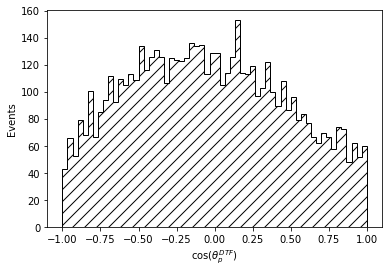

In [53]:
hist_arguments = {
    'bins': 60,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'hatch': '//',
}

xlabel = r"$\cos(\theta_p^{DTF})$"
ylabel = "Events"
title = r"Proton DTF $\theta$ helicity angle" + "\n" + "(Run 2 data, filtered)"
file_name = 'RUN2_theta_reco'

plt.hist(df_data['DTF_FixJPsiLambda_p_CosTheta'], **hist_arguments)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_titles:
    plt.title(title)
    
if save_plots:
    plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

plt.show()

### Deep background

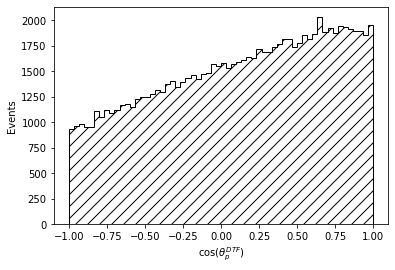

In [54]:
hist_arguments = {
    'bins': 60,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'hatch': '//',
}

xlabel = r"$\cos(\theta_p^{DTF})$"
ylabel = "Events"
title = r"Proton DTF $\theta$ helicity angle" + "\n" + "(Run 2 data, deep background)"
file_name = 'BKG_theta_reco'

plt.hist(df_deep_background['DTF_FixJPsiLambda_p_CosTheta'], **hist_arguments)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_titles:
    plt.title(title)
    
if save_plots:
    plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

plt.show()

# Proton $\phi$ angle
## Simulation
### All simulated events

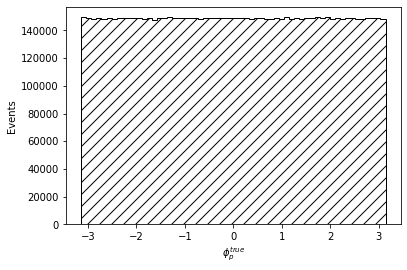

In [55]:
hist_arguments = {
    'bins': 60,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'hatch': '//'
}

xlabel = r"$\phi_p^{true}$"
ylabel = "Events"
title = r"Proton true $\phi$ helicity angle" + "\n" + "(MC simulation, truth sample)"
file_name = 'MCTRUTH_phi_true'

plt.hist(df_truth['MCTRUTH_p_Phi'], **hist_arguments)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_titles:
    plt.title(title)
    
if save_plots:
    plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

plt.show()

### Only reconstructed events

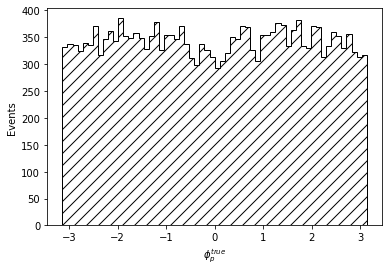

In [56]:
hist_arguments = {
    'bins': 60,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'hatch': '//'
}

xlabel = r"$\phi_p^{true}$"
ylabel = "Events"
title = r"Proton true $\phi$ helicity angle" + "\n" + "(MC simulation, reco sample)"
file_name = 'MCRECO_phi_true'

plt.hist(df_mc['MCTRUTH_p_Phi'], **hist_arguments)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_titles:
    plt.title(title)
    
if save_plots:
    plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

plt.show()

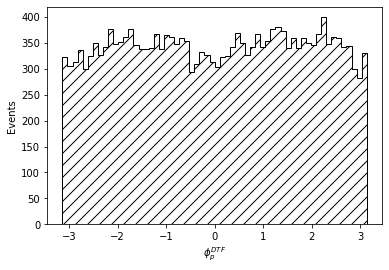

In [57]:
hist_arguments = {
    'bins': 60,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'hatch': '//'
}

xlabel = r"$\phi_p^{DTF}$"
ylabel = "Events"
title = r"Proton DTF $\phi$ helicity angle" + "\n" + "(MC simulation, reco sample)"
file_name = 'MCRECO_phi_reco'

plt.hist(df_mc['DTF_FixJPsiLambda_p_Phi'], **hist_arguments)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_titles:
    plt.title(title)
    
if save_plots:
    plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

plt.show()

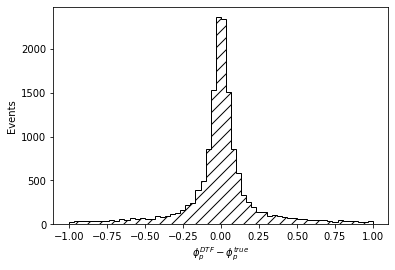

In [58]:
hist_arguments = {
    'bins': 60,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'hatch': '//',
    'range': (-1,1)
}

xlabel = r"$\phi_p^{DTF} - \phi_p^{true}$"
ylabel = "Events"
title = r"Proton $\phi$ helicity angle bias" + "\n" + "(MC simulation, reco sample)"
file_name = 'MCRECO_phi_bias'

plt.hist(
    df_mc['DTF_FixJPsiLambda_p_Phi'] - df_mc['MCTRUTH_p_Phi'],
    **hist_arguments)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_titles:
    plt.title(title)
    
if save_plots:
    plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

plt.show()

## Run 2 data
### Discriminated signal with background

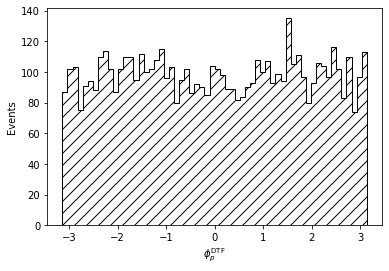

In [59]:
hist_arguments = {
    'bins': 60,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'hatch': '//',
}

xlabel = r"$\phi_p^\mathrm{DTF}$"
ylabel = "Events"
title = r"Proton DTF $\phi$ helicity angle" + "\n" + "(Run 2 data, filtered)"
file_name = 'RUN2_phi_reco'

plt.hist(df_data['DTF_FixJPsiLambda_p_Phi'], **hist_arguments)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_titles:
    plt.title(title)
    
if save_plots:
    plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

plt.show()

### Deep background

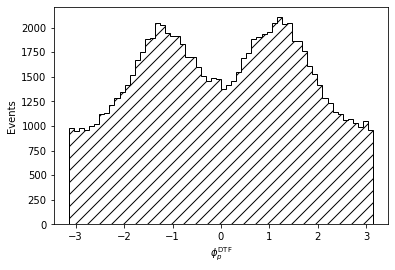

In [60]:
hist_arguments = {
    'bins': 60,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'hatch': '//',
}

xlabel = r"$\phi_p^\mathrm{DTF}$"
ylabel = "Events"
title = r"Proton DTF $\phi$ helicity angle" + "\n" + "(Run 2 data, deep background)"
file_name = 'BKG_phi_reco'

plt.hist(df_deep_background['DTF_FixJPsiLambda_p_Phi'], **hist_arguments)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

if show_titles:
    plt.title(title)
    
if save_plots:
    plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

plt.show()